<a href="https://colab.research.google.com/github/Osterne/codes_podcast/blob/main/Episodio_02_Valores_Shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

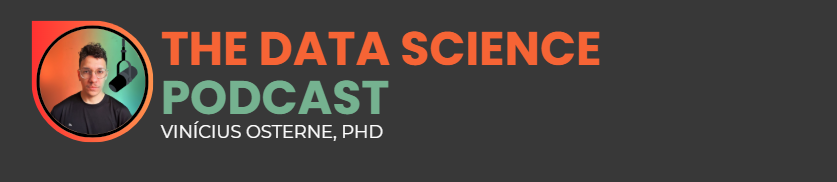


# Episódio 02 - Valores Shap

## Dúvida de um seguidor

“Professor, eu vejo muita gente falando de SHAP nos modelos de machine learning, mas não entendo direito. Se o modelo já me dá a importância das variáveis, pra que serve o SHAP? Ele realmente consegue mostrar quanto cada atributo influenciou a previsão de cada cliente? Como funciona essa tal de contribuição individual?”

## Exemplo fictício:

*   Número de transações nas últimas 24h – Detecta padrões anormais de atividade.
*   Número de dispositivos diferentes usados para login – Indica possível comprometimento de conta.
*   Tentativas de senha incorreta – Comportamento típico de ataques ou fraude.
*   Tempo de sessão - Tempo de uso em segundos
*   Valor medio da transação = valor médio do ticket solicitado em R$

## Análise

In [38]:
!pip install h2o

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

In [40]:
# ===============================
# 1. Criar base artificial
# ===============================
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 2000

# Variáveis comportamentais
transacoes_24h = np.random.poisson(lam=2, size=n_samples)               # discreta
dispositivos = np.random.randint(1, 5, n_samples)                       # discreta
tentativas_senha = np.random.poisson(lam=1, size=n_samples)              # discreta

# Variáveis contínuas
tempo_sessao = np.random.exponential(scale=300, size=n_samples)          # tempo de sessão em segundos
valor_medio_transacao = np.random.normal(loc=500, scale=200, size=n_samples)  # valor médio em R$

# Ajuste para manter valores positivos
valor_medio_transacao = np.clip(valor_medio_transacao, 50, None)

# Lógica da fraude:
# - Fraudes ocorrem com muitas tentativas de senha e dispositivos diferentes
# - Pouquíssimas transações (fraude discreta)
# - Sessão muito longa ou valor médio muito alto também aumenta risco
fraude = (
    ((tentativas_senha > 2) & (dispositivos > 2)) |
    ((transacoes_24h < 1) & (tentativas_senha > 0)) |
    (tempo_sessao > 800) |
    (valor_medio_transacao > 1000)
).astype(int)

df = pd.DataFrame({
    'transacoes_24h': transacoes_24h,
    'dispositivos': dispositivos,
    'tentativas_senha': tentativas_senha,
    'tempo_sessao': tempo_sessao,
    'valor_medio_transacao': valor_medio_transacao,
    'fraude': fraude
})

df.shape

(2000, 6)

In [41]:
df.head(5)

,transacoes_24h,dispositivos,tentativas_senha,tempo_sessao,valor_medio_transacao,fraude
0,4,3,1,662.496647,50.000000,0
1,1,1,1,587.797207,499.227544,0
2,3,2,0,23.949215,385.474599,0
3,3,4,0,33.745217,529.163620,0
4,1,1,1,205.061008,718.525513,0


In [42]:
df["fraude"].value_counts(dropna = False)

,count
fraude,
0,1618
1,382


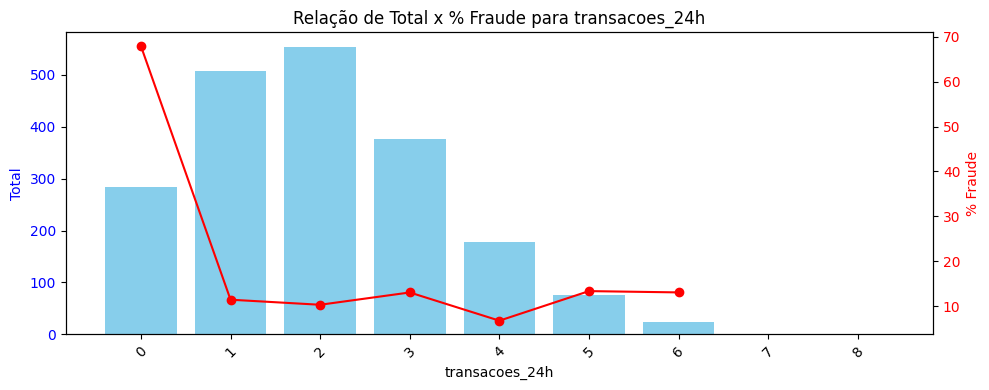

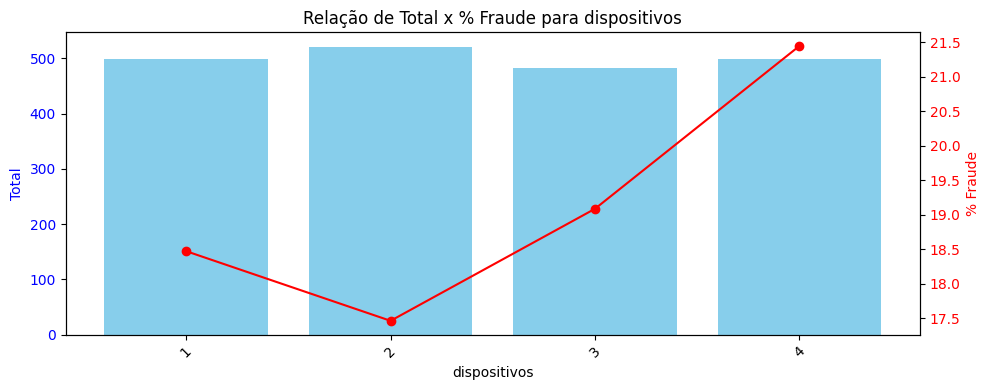

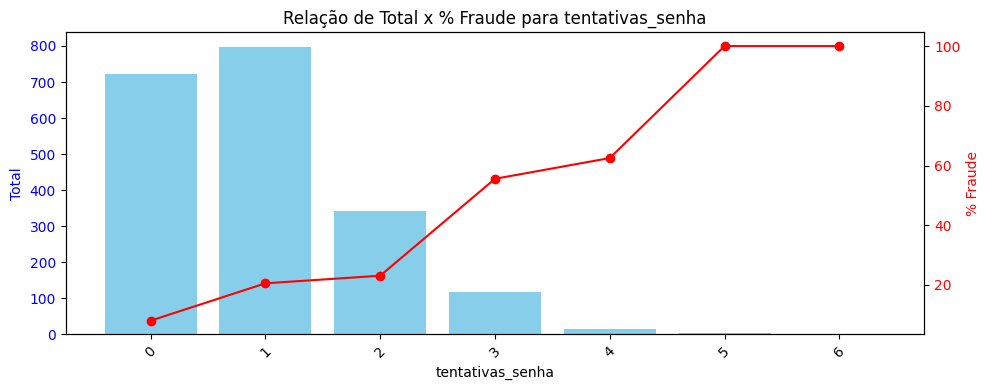

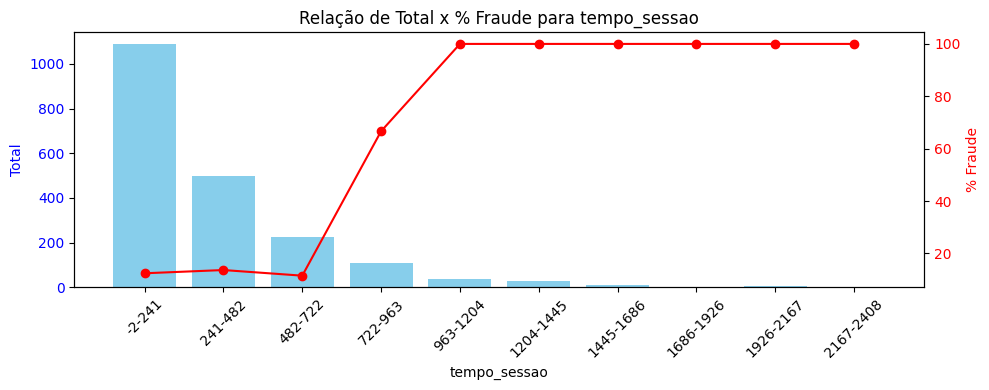

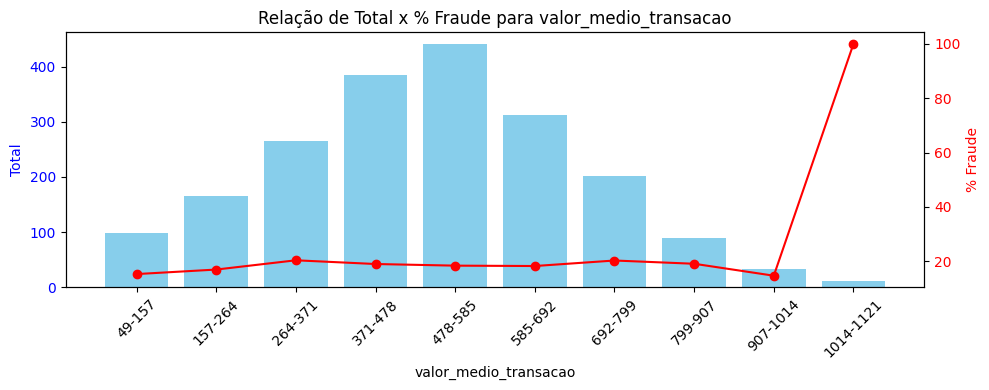

In [43]:
# ===============================
# 2. Análise descritiva
# ===============================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_bivariada_misto(df, variavel, bins=10):
    # Se a variável for contínua, criar faixas
    if pd.api.types.is_numeric_dtype(df[variavel]) and df[variavel].nunique() > 20:
        df_plot = df.copy()
        df_plot[variavel + '_bin'] = pd.cut(df_plot[variavel], bins=bins)
        total = df_plot[variavel + '_bin'].value_counts().sort_index()
        pct_fraude = (
            df_plot[df_plot['fraude'] == 1][variavel + '_bin'].value_counts().sort_index()
            / total
        ) * 100
        x_labels = [f"{interval.left:.0f}-{interval.right:.0f}" for interval in total.index]
    else:
        total = df[variavel].value_counts().sort_index()
        pct_fraude = (
            df[df['fraude'] == 1][variavel].value_counts().sort_index() / total
        ) * 100
        x_labels = total.index.astype(str)

    # Criando gráfico misto
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Barras - Total
    ax1.bar(range(len(total)), total.values, color='skyblue', label='Total')
    ax1.set_xlabel(variavel)
    ax1.set_ylabel('Total', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(range(len(total)))
    ax1.set_xticklabels(x_labels, rotation=45)

    # Linha - % Fraude
    ax2 = ax1.twinx()
    ax2.plot(range(len(pct_fraude)), pct_fraude.values, color='red', marker='o', label='% Fraude')
    ax2.set_ylabel('% Fraude', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Relação de Total x % Fraude para {variavel}')
    fig.tight_layout()
    plt.show()

# Gerar gráfico misto para todas as variáveis
plot_bivariada_misto(df, 'transacoes_24h')
plot_bivariada_misto(df, 'dispositivos')
plot_bivariada_misto(df, 'tentativas_senha')
plot_bivariada_misto(df, 'tempo_sessao')
plot_bivariada_misto(df, 'valor_medio_transacao')


In [44]:
# ===============================
# 3. Treinar modelo GBM
# ===============================
# Iniciar H2O
h2o.init()

# Converter o dataframe para H2OFrame
hf = h2o.H2OFrame(df)

# Definir features e target (agora incluindo as contínuas)
features = [
    'transacoes_24h',
    'dispositivos',
    'tentativas_senha',
    'tempo_sessao',
    'valor_medio_transacao'
]
target = 'fraude'

# Converter target para categórico (fator)
hf[target] = hf[target].asfactor()

# Treinar modelo GBM
gbm_model = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=3,
    learn_rate=0.1,
    seed=42
)
gbm_model.train(x=features, y=target, training_frame=hf)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 hour 58 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_59pvq0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.169 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1753906081550_73


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         14616                  3            3            3             5             8             6.96

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 1.5948371500644653e-05
RMSE: 0.003993541223105711
LogLoss: 0.001623801989938393
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9029604027565832
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      1618  0    0        (0.0/1618.0)
1      0     382  0        (0.0/382.0)
Total  1618  382  0        (0.0/2000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.90296      1         54
max f2                       0.90296      1         54
max f0point5                 0.90296      1         54
max accuracy                 0.90296      1         54
max precision                0.999989     1         0
max recall                   0.90296      1         54
max specificity              0.999989     1         0
max absolute_mcc             0.90296      1         54
max min_per_class_accuracy   0.90296      1         54
max mean_per_class_accuracy  0.90296      1         54
max tns                      0.999989     1618      0
max fns                      0.999989     379       0
max fps                      0.000313783  1618      65
max tps                      0.90296      382       54
max tnr                      0.999989     1         0
max fnr                      0.999989     0.992147  0
max fpr                      0.000313783  1         65
max tpr                      0.90296      1         54

Gains/Lift Table: Avg response rate: 19.10 %, avg score: 19.10 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0105                      0.999819           5.2356   5.2356             1                0.999931     1                           0.999931            0.0549738       0.0549738                  423.56   423.56             0.0549738
2        0.02                        0.998754           5.2356   5.2356             1                0.999169     1                           0.999569            0.0497382       0.104712                   423.56   423.56             0.104712
3        0.0455                      0.998727           5.2356   5.2356             1                0.998732     1                           0.9991              0.133508        0.23822                    423.56   423.56             0.23822
4        0.05                        0.997977           5.2356   5.2356             1                0.998345     1                           0.999032            0.0235602       0.26178                    423.56   423.56             0.26178
5        0.1535                      0.995466           5.2356   5.2356             1                0.995983     1                           0.996976            0.541885        0.803665                   423.56   423.56          

In [45]:
# ===============================
# 4. Importância das variáveis
# ===============================
# Importância das variáveis
importancia = gbm_model.varimp(use_pandas=True)

# Mostrar
print(importancia)

                variable  relative_importance  scaled_importance  percentage
0           tempo_sessao           523.196411           1.000000    0.322982
1         transacoes_24h           472.423126           0.902956    0.291639
2       tentativas_senha           438.510010           0.838137    0.270703
3           dispositivos           123.390717           0.235840    0.076172
4  valor_medio_transacao            62.371124           0.119212    0.038503


In [ ]:
# ===============================
# 5. Shap values
# ===============================

**Como funciona a ideia?**

Os valores **SHAP** são calculados **a partir da predição do modelo** (log-odds ou probabilidade).

A ideia é decompor a saída do modelo em uma soma de contribuições:

$$
f(x) = \phi_0 + \phi_1 + \phi_2 + \dots + \phi_p
$$

- $f(x)$: saída do modelo (geralmente o **log-odds**)  
- $\phi_0$: valor base (média das predições no treino)  
- $\phi_i$: contribuição do atributo \(i\) (o valor SHAP)

---

**Como se chega ao valor?**

Para cada atributo:

- O algoritmo “simula” a **inclusão e exclusão** desse atributo em todas as possíveis combinações de atributos.  
- Mede quanto a **previsão muda** nessas diferentes combinações.  
- Esse processo é uma **marginalização** (esperança condicional), **não apenas fixar o atributo e variar o outro**.

Para um atributo \(i\), o valor SHAP \(\phi_i\) é calculado assim:

$$
\phi_i = \sum_{S \subseteq F \setminus \{i\}}
\frac{|S|! \, (|F| - |S| - 1)!}{|F|!}
\Big[f_{S \cup \{i\}}(x_{S \cup \{i\}}) - f_S(x_S)\Big]
$$

- \(F\): conjunto de todos os atributos  
- \(S\): subconjunto de atributos que não inclui \(i\)  
- \(f_S(x_S)\): predição do modelo usando apenas os atributos de \(S\)

O termo de peso

$$
\frac{|S|! \, (|F| - |S| - 1)!}{|F|!}
$$

garante que todas as ordens possíveis são igualmente consideradas.

---

**Interpretação**

Para cada subconjunto \(S\), o algoritmo:

1. Calcula a previsão **sem** o atributo \(i\): \(f_S(x_S)\)  
2. Calcula a previsão **com** o atributo \(i\): \(f_{S \cup \{i\}}(x_{S \cup \{i\}})\)  
3. Mede a diferença (quanto o atributo mudou a previsão)  

Depois, faz a **média ponderada** dessa diferença considerando todas as possíveis ordens.



In [46]:
# Obter SHAP values
shap_values = gbm_model.predict_contributions(hf)
shap_values.head(5)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


transacoes_24h,dispositivos,tentativas_senha,tempo_sessao,valor_medio_transacao,BiasTerm
-1.49341,0.180006,-0.0707044,-0.949644,-0.0540152,-4.8135
-1.49531,-0.163865,0.294674,-0.944793,-0.0784759,-4.8135
-0.799933,-0.163865,-1.23722,-0.970243,-0.0817338,-4.8135
-0.789905,0.180006,-1.59469,-0.966179,-0.0822261,-4.8135
-1.49531,-0.163865,0.294674,-0.944793,-0.0784759,-4.8135


In [47]:
# Selecionar uma observação
hf_sample = hf[0:1, :]

# Calcular contribuições só para ela
shap_single = gbm_model.predict_contributions(hf_sample)
shap_single

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


transacoes_24h,dispositivos,tentativas_senha,tempo_sessao,valor_medio_transacao,BiasTerm
-1.49341,0.180006,-0.0707044,-0.949644,-0.0540152,-4.8135


In [48]:
# A predição nesse caso, seria:

log_odds_final = -1.49341	+ 0.180006 - 0.0707044 - 0.949644 - 0.0540152 - 4.8135
prob_fraude = 1/(1+np.exp(-(log_odds_final)))
print(f"Probabilidade de fraude: {prob_fraude:.6f}") # o modelo está classificando essa observação como não fraude com alta confiança

Probabilidade de fraude: 0.000745


In [49]:
import pandas as pd

# Converter para pandas
shap_df = shap_values.as_data_frame()

# Remover BiasTerm
shap_df = shap_df.drop(columns=['BiasTerm'])

# Importância média absoluta
mean_shap = shap_df.abs().mean().sort_values(ascending=False)

print(mean_shap)

transacoes_24h           2.028767
tempo_sessao             1.664391
tentativas_senha         1.298463
dispositivos             0.330988
valor_medio_transacao    0.143260
dtype: float64


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


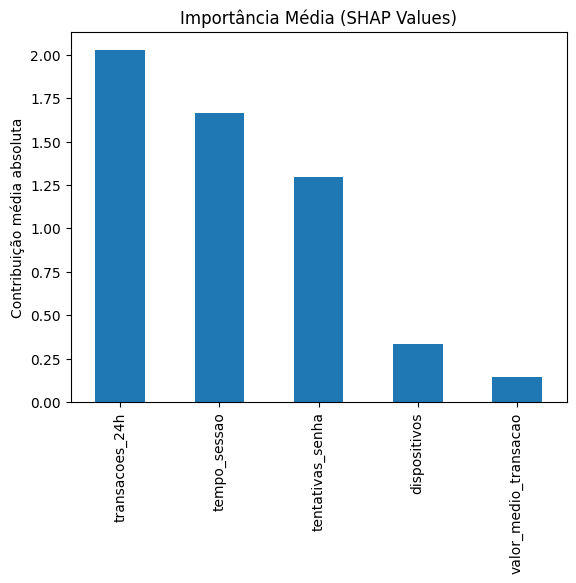

In [ ]:
import matplotlib.pyplot as plt

mean_shap.plot(kind='bar')
plt.title("Importância Média (SHAP Values)")
plt.ylabel("Contribuição média absoluta")
plt.show()

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/tmp/ipython-input-2783683259.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in 

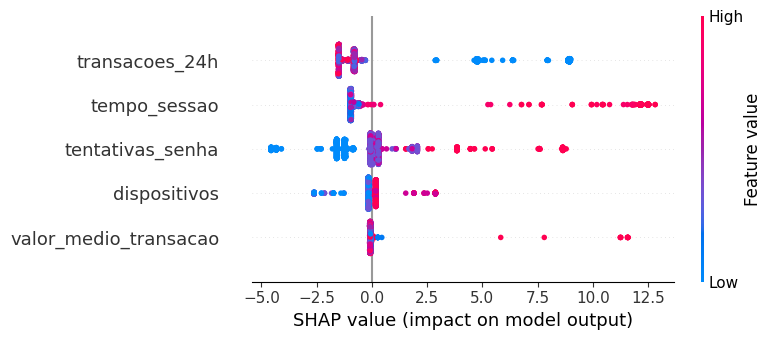

In [ ]:
import shap
import numpy as np

# Calcular contribuições SHAP
shap_values = gbm_model.predict_contributions(hf).as_data_frame()

# Remover o BiasTerm
shap_values = shap_values.drop(columns=['BiasTerm'])

# Dados originais para colorir os pontos
df_features = hf.as_data_frame()[features]

# Converter para numpy
X = df_features.values
feature_names = df_features.columns
shap_vals = shap_values.values

# Beeswarm plot
shap.summary_plot(shap_vals, features=X, feature_names=feature_names)

contributions progress: |

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


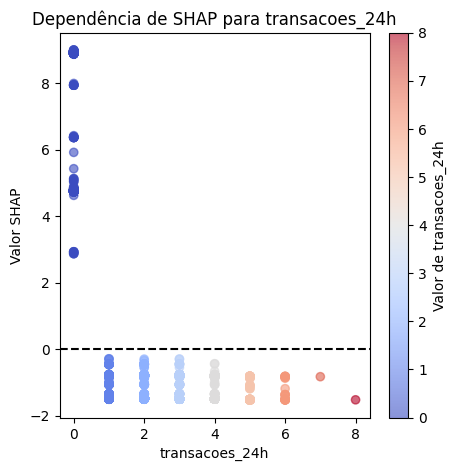

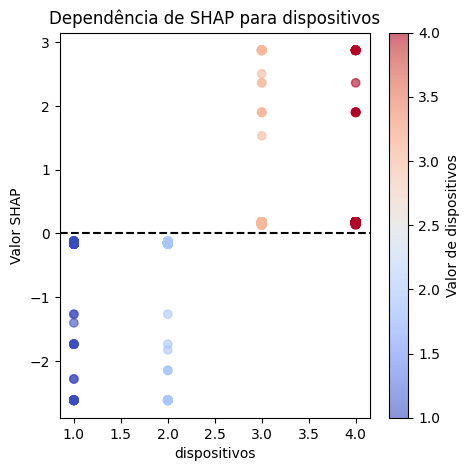

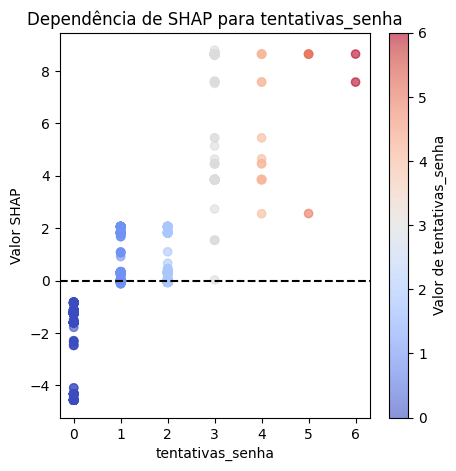

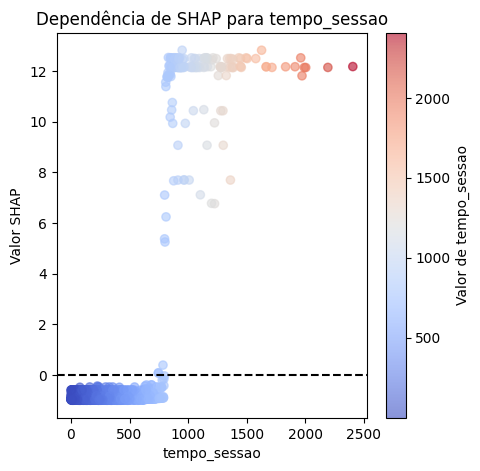

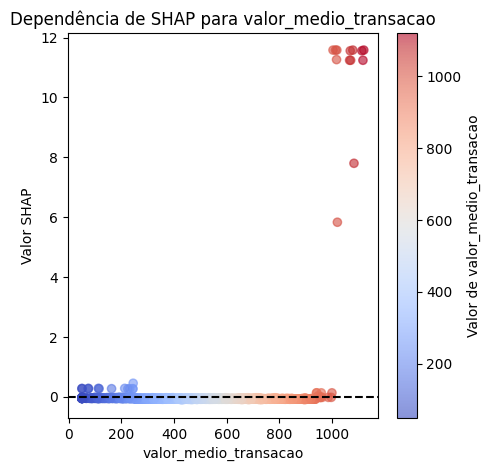

In [ ]:
import matplotlib.pyplot as plt

# Converter dados para pandas
train_data = hf.as_data_frame()  # dataset usado no treino
shap_df = gbm_model.predict_contributions(hf).as_data_frame()

# Remover coluna do bias
if 'BiasTerm' in shap_df.columns:
    shap_df = shap_df.drop(columns=['BiasTerm'])

# Lista de atributos
features = [
    'transacoes_24h',
    'dispositivos',
    'tentativas_senha',
    'tempo_sessao',
    'valor_medio_transacao'
]

# Loop para mostrar gráficos
for col in features:
    plt.figure(figsize=(5, 5))
    plt.scatter(
        train_data[col],
        shap_df[col],
        c=train_data[col],     # colorir pelos valores do atributo
        cmap='coolwarm',
        alpha=0.6
    )
    plt.axhline(0, color='black', linestyle='--')
    plt.colorbar(label=f'Valor de {col}')
    plt.xlabel(col)
    plt.ylabel('Valor SHAP')
    plt.title(f'Dependência de SHAP para {col}')
    plt.show()

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/tmp/ipython-input-2783683259.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in 

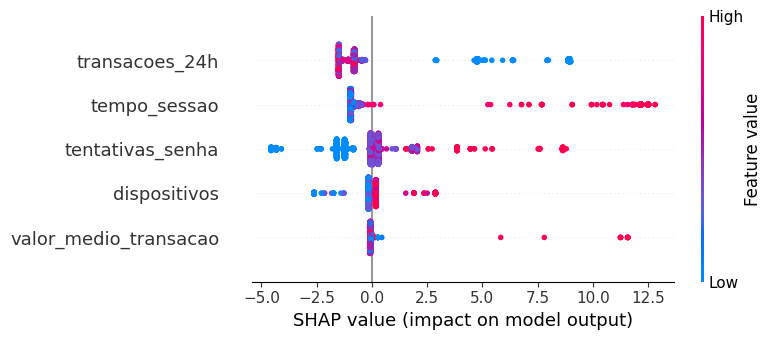